Import Necessary Packages

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.regression.rolling import RollingOLS
import yfinance as yf
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

For illustration purpose, I choose FAANG stocks within S&P500.

In [3]:
symbol_list = ['META','AMZN','AAPL','NFLX','GOOG']
data = yf.download(
    symbol_list,
    start= '2018-01-01',
    end='2022-01-01'
)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [4]:
symbol_list = list(data.keys())

In [5]:
min_pvalue = 0.07

In [6]:
def find_cointegrated_pairs(data,min_pvalue):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < min_pvalue:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [7]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks
scores, pvalues, pairs = find_cointegrated_pairs(data,min_pvalue)
print(pairs)

[('META', 'NFLX')]


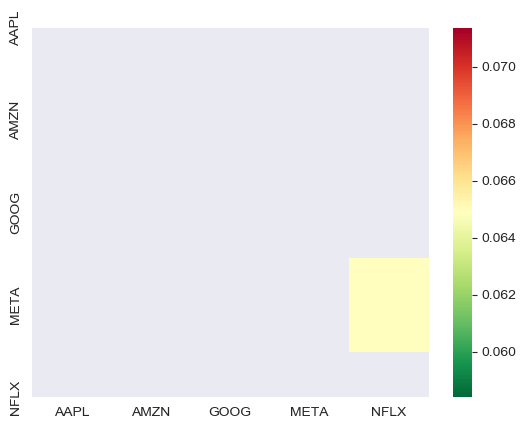

In [8]:
seaborn.heatmap(
    pvalues,
    xticklabels=symbol_list,
    yticklabels=symbol_list,
    cmap='RdYlGn_r',
    mask = (pvalues >min_pvalue))
plt.show()

In [9]:
S1 = data['META']
S2 = data['NFLX']

In [10]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [11]:
X = sm.add_constant(S1)
result = (sm.OLS(S2,X)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   NFLX   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     3668.
Date:                Wed, 11 Jan 2023   Prob (F-statistic):               0.00
Time:                        01:38:03   Log-Likelihood:                -5401.0
No. Observations:                1008   AIC:                         1.081e+04
Df Residuals:                    1006   BIC:                         1.082e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         75.3818      5.812     12.969      0.0

In [12]:
b = result.params['META']
c = result.params['const']
spread = S2 - (b*S1 + c)

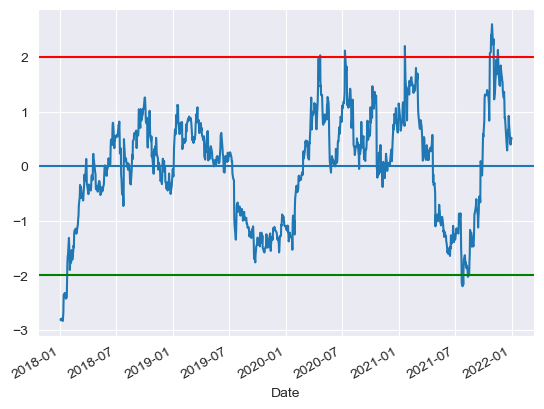

In [13]:
zscore(spread).plot()
plt.axhline(zscore(spread).mean())
plt.axhline(2, color='red')
plt.axhline(-2, color='green')
plt.show()

Event Driven Backtesting

In [14]:
import backtrader as bt
import backtrader.indicators as btind
import pyfolio as pf

In [15]:
trading_pair = ['META', 'NFLX']

In [16]:
class PairTradingStrategy(bt.Strategy):
    params = dict(
        period=25,
        stake=10,
        qty1=0,
        qty2=0,
        printout=False,
        upper=2,
        lower=-2,
        status=0,
        portfolio_value=10000,
    )

    def log(self, txt, dt=None):
        if self.p.printout:
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = 'BUY COMPLETE, %.2f' % order.executed.price
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = 'SELL COMPLETE, %.2f' % order.executed.price
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('%s ,' % order.Status[order.status])
            pass  # Simply log

        # Allow new orders
        self.orderid = None

    def __init__(self):
        # To control operation entries
        self.orderid = None
        self.qty1 = self.p.qty1
        self.qty2 = self.p.qty2
        self.upper_limit = self.p.upper
        self.lower_limit = self.p.lower
        self.status = self.p.status
        self.portfolio_value = self.p.portfolio_value

        # Signals performed with PD.OLS :
        self.transform = btind.OLS_TransformationN(self.data0, self.data1,
                                                   period=self.p.period)
        self.zscore = self.transform.zscore

    def next(self):

        if self.orderid:
            return  # if an order is active, no new orders are allowed

        if self.p.printout:
            print('Self  len:', len(self))
            print('Data0 len:', len(self.data0))
            print('Data1 len:', len(self.data1))
            print('Data0 len == Data1 len:',len(self.data0) == len(self.data1))
            print('Data0 dt:', self.data0.datetime.datetime())
            print('Data1 dt:', self.data1.datetime.datetime())
            print('status is', self.status)
            print('zscore is', self.zscore[0])

        # Step 2: Check conditions for SHORT & place the order
        # Checking the condition for SHORT
        if (self.zscore[0] > self.upper_limit) and (self.status != 1):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2
            print('x + self.qty1 is', x + self.qty1)
            print('y + self.qty2 is', y + self.qty2)

            # Placing the order
            self.sell(data=self.data0, size=(x + self.qty1))  # Place an order for buying y + qty2 shares
            self.buy(data=self.data1, size=(y + self.qty2))  # Place an order for selling x + qty1 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares

            self.status = 1  # The current status is "short the spread"

            # Step 3: Check conditions for LONG & place the order
            # Checking the condition for LONG
        elif (self.zscore[0] < self.lower_limit) and (self.status != 2):

            # Calculating the number of shares for each stock
            value = 0.5 * self.portfolio_value  # Divide the cash equally
            x = int(value / (self.data0.close))  # Find the number of shares for Stock1
            y = int(value / (self.data1.close))  # Find the number of shares for Stock2

            # Place the order
            self.buy(data=self.data0, size=(x + self.qty1))  # Place an order for buying x + qty1 shares
            self.sell(data=self.data1, size=(y + self.qty2))  # Place an order for selling y + qty2 shares

            # Updating the counters with new value
            self.qty1 = x  # The new open position quantity for Stock1 is x shares
            self.qty2 = y  # The new open position quantity for Stock2 is y shares
            self.status = 2  # The current status is "long the spread"


    def stop(self):
        print('==================================================')
        print('Starting Value : %.2f' % self.broker.startingcash)
        print('Ending   Value : %.2f' % self.broker.getvalue())
        print('==================================================')


In [17]:
class all_backtest_args:
    def __init__(self, trading_pair):
        #1st data into the system
        self.data0 = trading_pair[0]
        #2nd data into the system
        self.data1 = trading_pair[1]

    #Starting date in YYYY-MM-DD format
    fromdate = '2018-01-01'
    #To date in YYYY-MM-DD format
    todate = '2022-01-01'
    #Starting Cash
    cash = 10000
    #Percentage commission (0.005 is 0.5%)
    commperc = 0.005


In [18]:
args = all_backtest_args(trading_pair)

# Create a cerebro
cerebro = bt.Cerebro()

# Create the 1st data
data0 = bt.feeds.PandasData(dataname=yf.download(args.data0, args.fromdate, args.todate))

# Add the 1st data to cerebro
cerebro.adddata(data0)

# Create the 2nd data
data1 = bt.feeds.PandasData(dataname=yf.download(args.data1, args.fromdate, args.todate))

# Add the 2nd data to cerebro
cerebro.adddata(data1)

# Add the strategy
cerebro.addstrategy(PairTradingStrategy)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Add the commission - only stocks like a for each operation
cerebro.broker.setcash(args.cash)

# Add the commission - only stocks like a for each operation
cerebro.broker.setcommission(commission=args.commperc)

# And run it
results = cerebro.run()
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
x + self.qty1 is 57
y + self.qty2 is 30
x + self.qty1 is 60
y + self.qty2 is 29
x + self.qty1 is 64
y + self.qty2 is 31
x + self.qty1 is 56
y + self.qty2 is 26
x + self.qty1 is 55
y + self.qty2 is 28
x + self.qty1 is 47
y + self.qty2 is 30
x + self.qty1 is 46
y + self.qty2 is 25
x + self.qty1 is 42
y + self.qty2 is 21
x + self.qty1 is 38
y + self.qty2 is 19
x + self.qty1 is 35
y + self.qty2 is 20
x + self.qty1 is 36
y + self.qty2 is 17
x + self.qty1 is 37
y + self.qty2 is 18
x + self.qty1 is 31
y + self.qty2 is 18
x + self.qty1 is 28
y + self.qty2 is 18
x + self.qty1 is 27
y + self.qty2 is 15
Starting Value : 10000.00
Ending   Value : 13247.61


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.92,2020-01-29,2020-04-21,2021-07-30,393
1,11.69,2018-12-14,2019-01-15,2019-03-19,68
2,11.43,2018-07-11,2018-07-24,2018-08-03,18
3,10.85,2018-08-15,2018-10-02,2018-12-14,88
4,9.07,2019-06-27,2019-07-23,2020-01-29,155


Stress Events,mean,min,max
New Normal,0.03%,-5.17%,11.86%


Top 10 long positions of all time,max
Data1,37.64%


Top 10 short positions of all time,max
Data1,-126.31%


Top 10 positions of all time,max
Data1,126.31%


SpecificationError: nested renamer is not supported

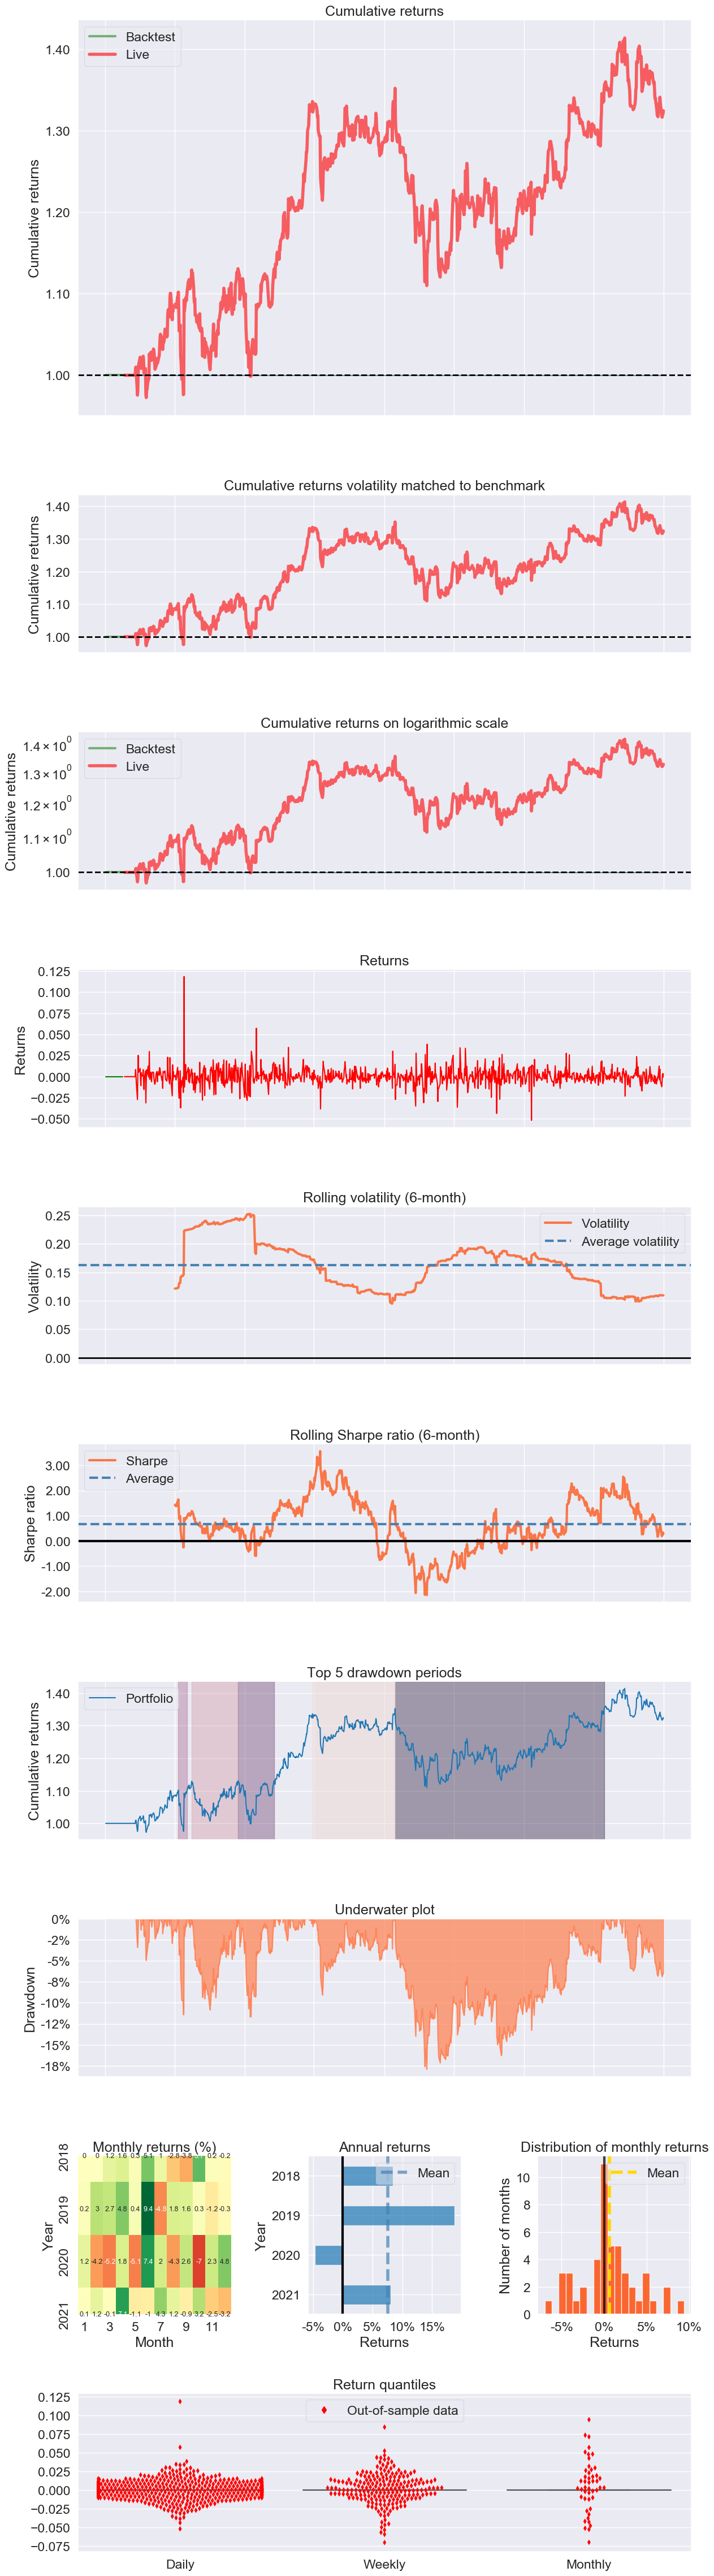

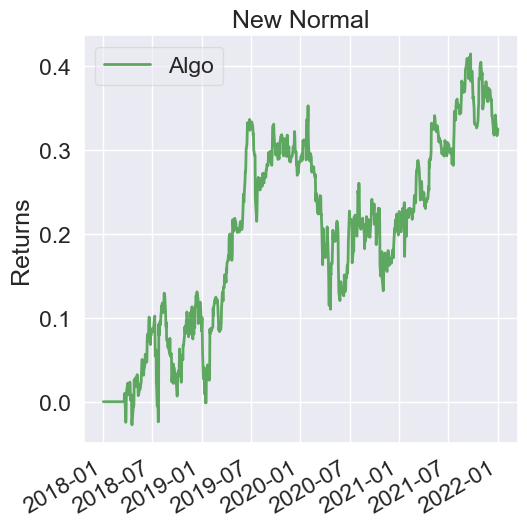

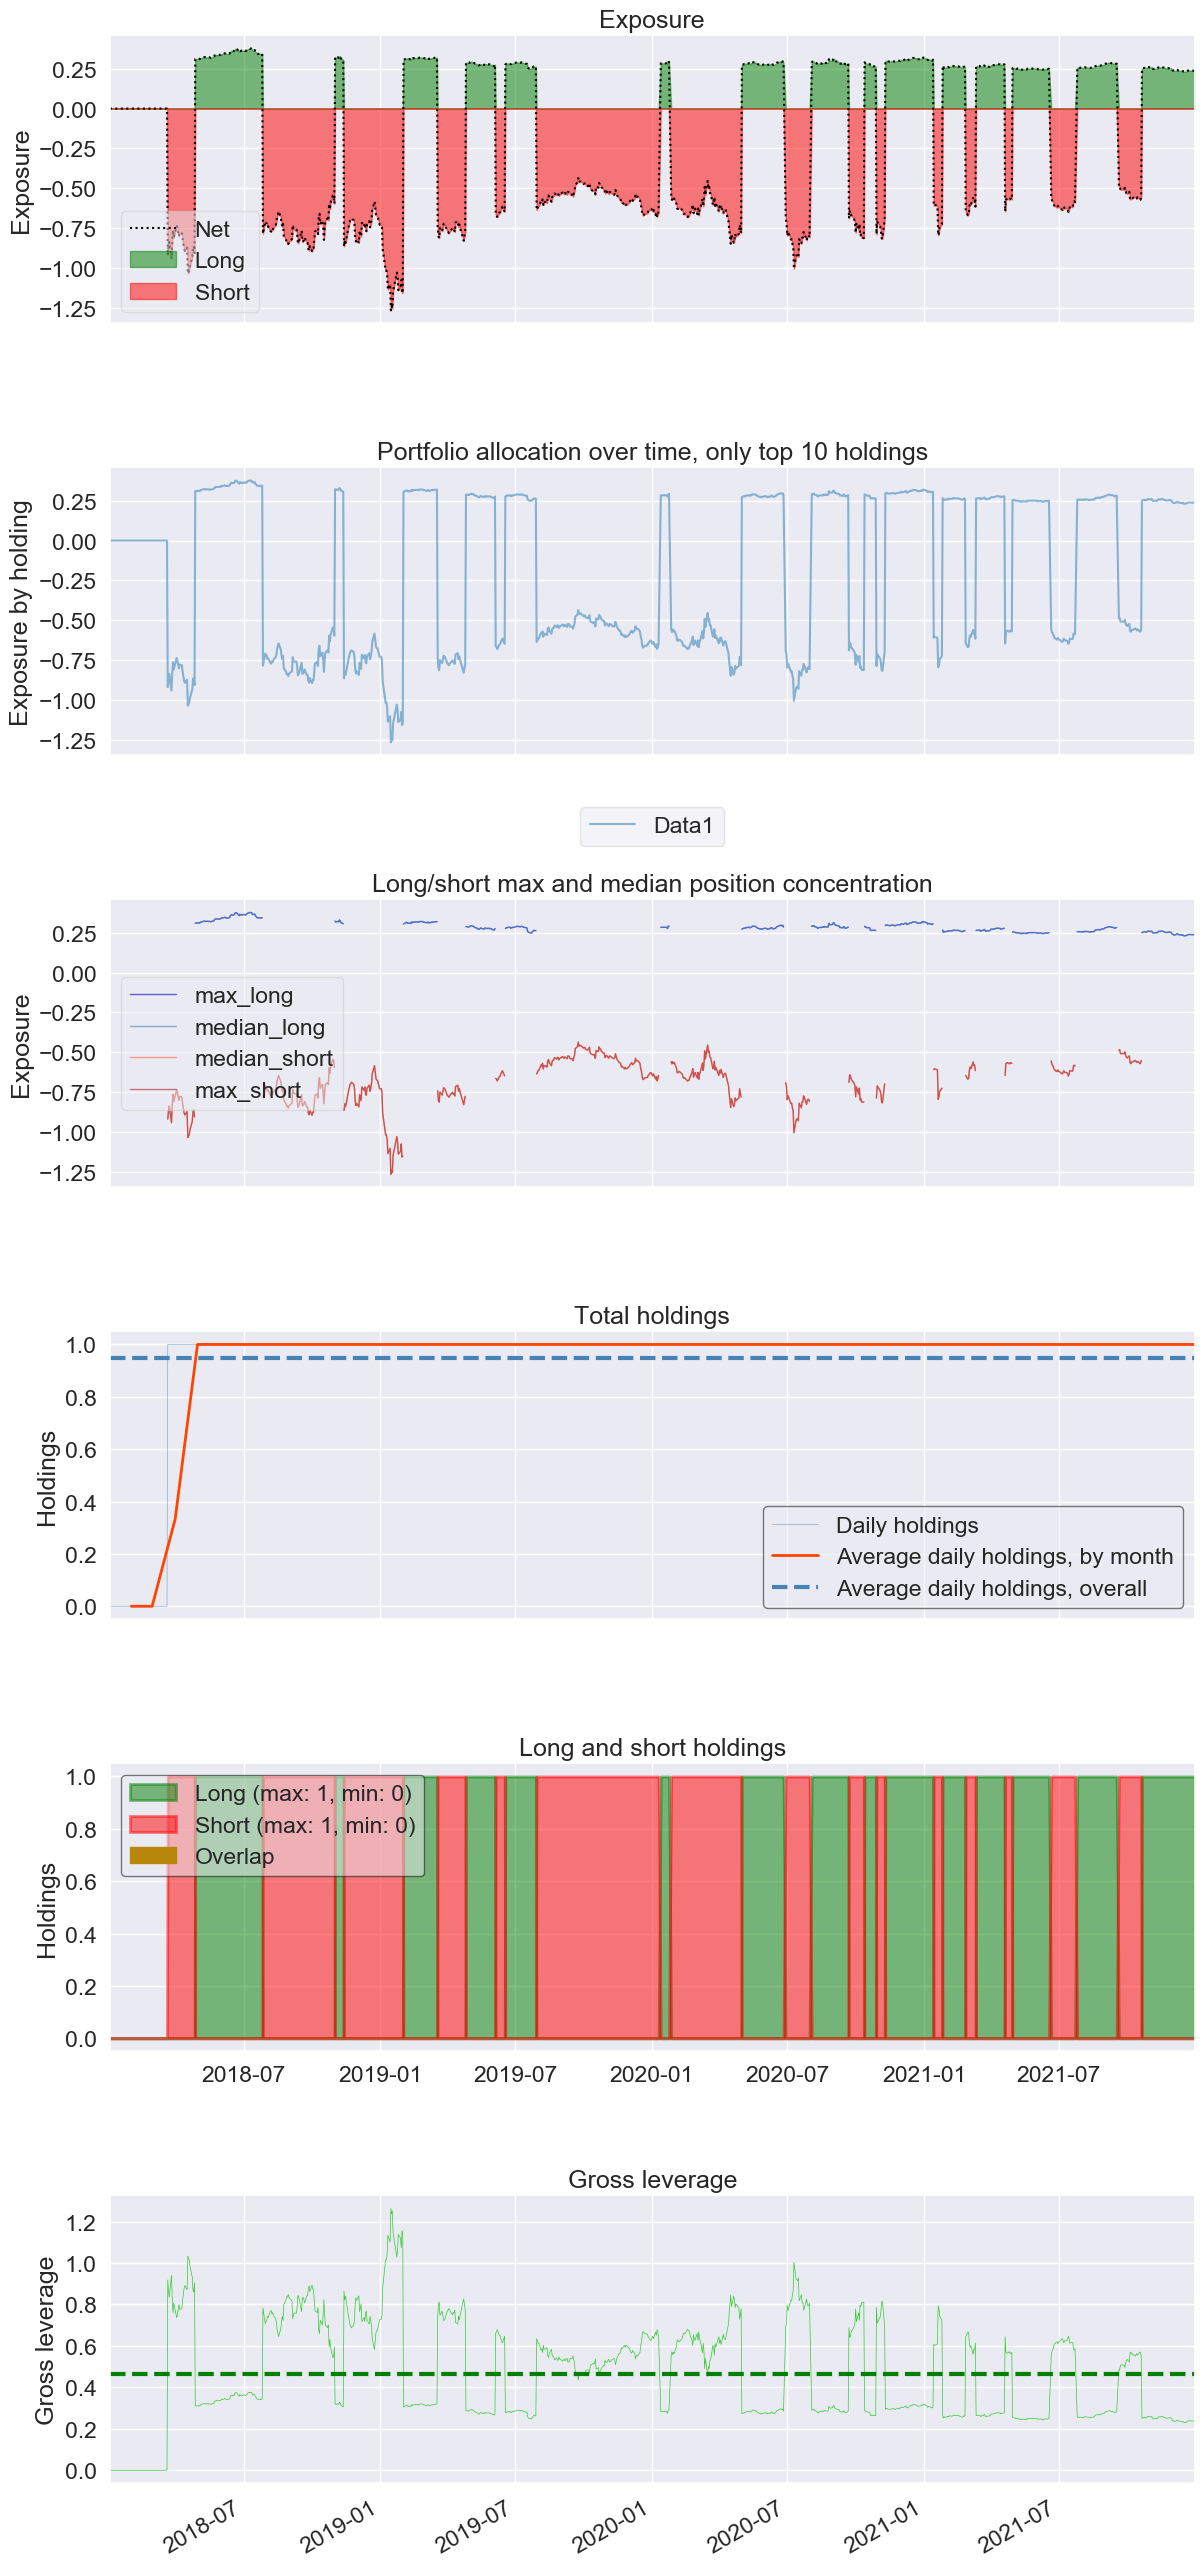

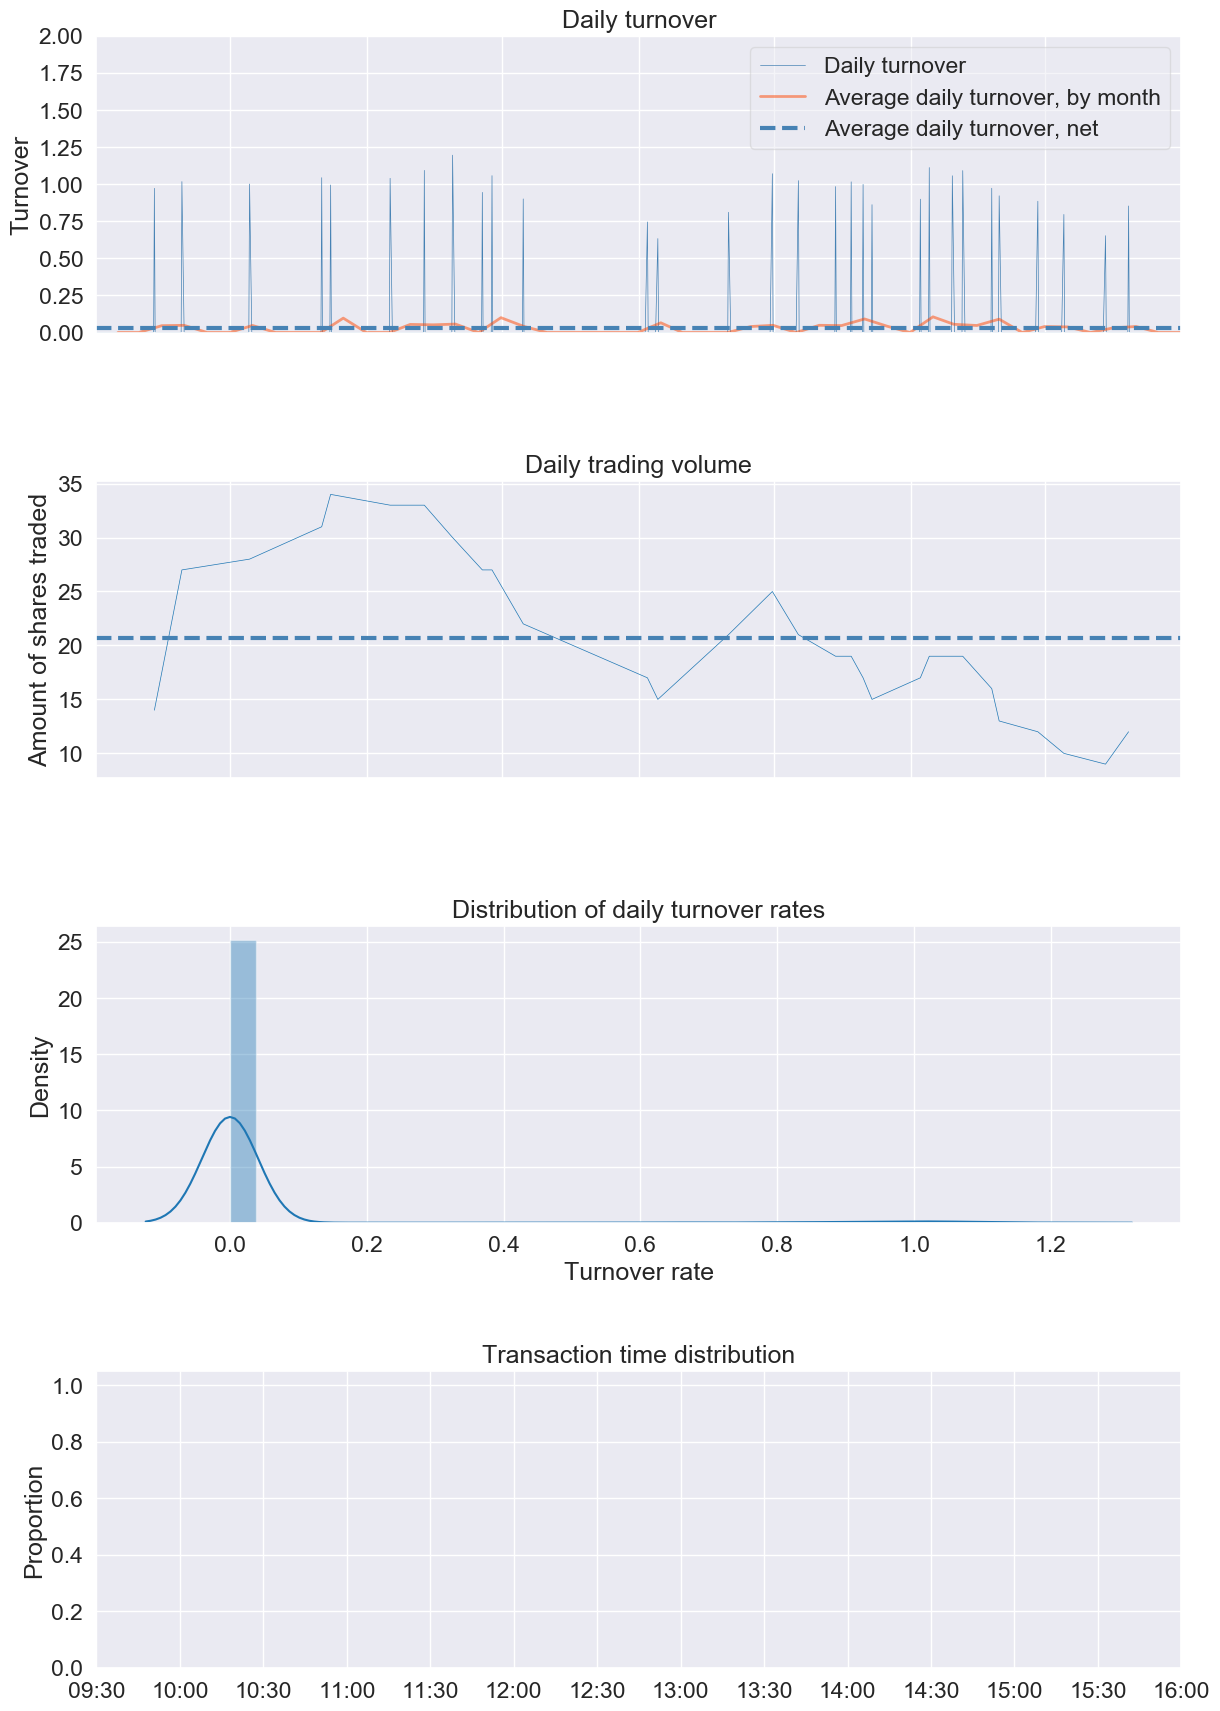

In [19]:
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date='2018-02-20',  # This date is sample specific
    round_trips=True)